In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()



## Preprocessing data

#### Hourly data

In [3]:
load_path = 'processed_data/data_2006_2023.csv'

In [4]:
load_data = pd.read_csv(load_path)

In [4]:
## to make sure that data is stationary

# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

In [5]:
adf_test(load_data["loadConsumption"])

ADF Statistic: -27.204566436886566
p-value: 0.0
Data is stationary


In [5]:
load_data["datetime"] = pd.to_datetime(load_data["datetime"])

In [6]:
load_data

,loadConsumption,date,datetime,Hour,Year
0,10215.0000,2006-01-01,2005-12-31 23:00:00,0,2006
1,9979.0000,2006-01-01,2006-01-01 00:00:00,1,2006
2,9460.0000,2006-01-01,2006-01-01 01:00:00,2,2006
3,8833.0000,2006-01-01,2006-01-01 02:00:00,3,2006
4,8525.0000,2006-01-01,2006-01-01 03:00:00,4,2006
...,...,...,...,...,...
157767,12673.4650,2023-12-31,2023-12-31 19:00:00,20,2023
157768,12366.1950,2023-12-31,2023-12-31 20:00:00,21,2023
157769,12143.1775,2023-12-31,2023-12-31 21:00:00,22,2023
157770,11993.1200,2023-12-31,2023-12-31 22:00:00,23,2023


In [8]:
load_data.set_index("datetime", inplace=True)

In [9]:
avg_hourly_load = load_data.groupby(['Year', 'Hour'])['loadConsumption'].mean().reset_index()

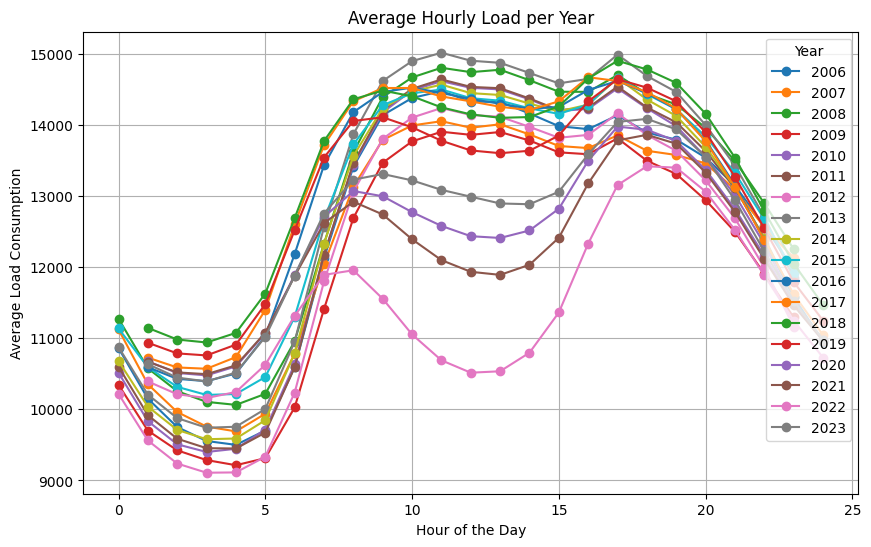

In [11]:
# Set the figure size for better readability
plt.figure(figsize=(10, 6))

# Loop through each unique year and plot its average load by hour
for year in avg_hourly_load['Year'].unique():
    subset = avg_hourly_load[avg_hourly_load['Year'] == year]
    plt.plot(subset['Hour'], subset['loadConsumption'], marker='o', label=str(year))

# Label the axes and add a title
plt.xlabel('Hour of the Day')
plt.ylabel('Average Load Consumption')
plt.title('Average Hourly Load per Year')
plt.legend(title='Year')
plt.grid(True)

# Save the plot as a PNG image
plt.savefig('average_hourly_load_per_year.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

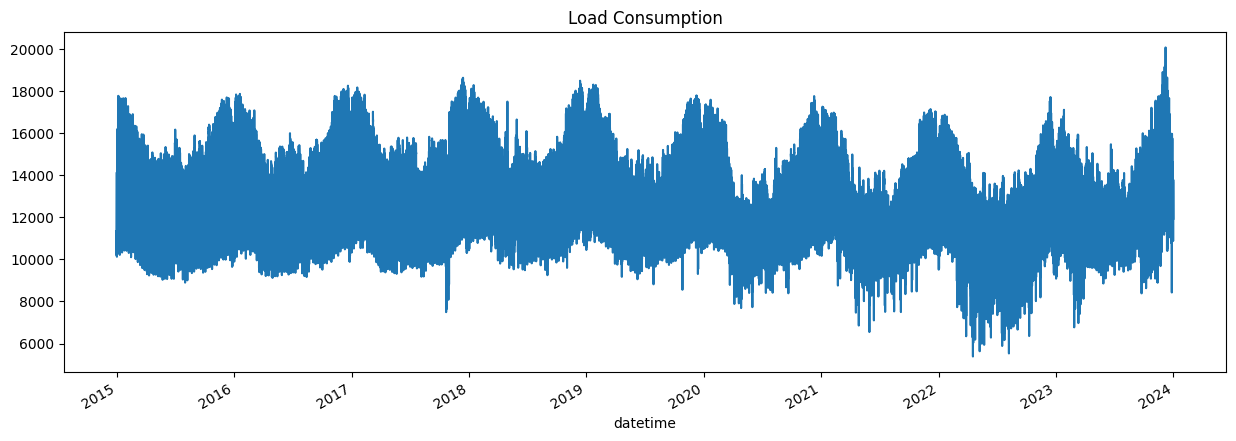

In [13]:
start_date = '2015-01-01'
end_date = '2023-12-31'

filtered_data = load_data.loc[start_date:end_date]
filtered_data['loadConsumption'].plot(
    style='-',
    figsize=(15, 5),
    color=color_pal[0],
    title='Load Consumption'
)

plt.savefig('Load_Consumption.png', dpi=300, bbox_inches='tight')

plt.show()

### Daily data

In [48]:
# Resample to daily data using sum
dailyLoad_data = filtered_data.groupby("date")["loadConsumption"].sum().reset_index()


In [49]:
#dailyLoad_data.set_index("date", inplace=True)

In [50]:
dailyLoad_data

,date,loadConsumption
0,2015-01-01,275667.0000
1,2015-01-02,319026.0000
2,2015-01-03,313131.0000
3,2015-01-04,296832.0000
4,2015-01-05,350937.0000
...,...,...
3282,2023-12-27,305610.2900
3283,2023-12-28,326312.3400
3284,2023-12-29,314575.3300
3285,2023-12-30,290563.1625


In [51]:
# Create lag features for the past 7 days
#for lag in range(1, 8):  # Lags for the past 7 days
#    dailyLoad_data[f'lag_{lag}'] = dailyLoad_data['loadConsumption'].shift(lag)

# Drop rows with NaN values created by shifting
#dailyLoad_data.dropna(inplace=True)

In [52]:
# Add rolling mean and standard deviation for the past 7 days
#dailyLoad_data['rolling_mean_7'] = dailyLoad_data['loadConsumption'].rolling(window=7).mean()
#dailyLoad_data['rolling_std_7'] = dailyLoad_data['loadConsumption'].rolling(window=7).std()

# Drop rows with NaN values created by rolling
#dailyLoad_data.dropna(inplace=True)

In [53]:
# weather data
weather_data_path = 'processed_data/weather.csv' 
weather_data = pd.read_csv(weather_data_path)

In [54]:
#weather_data.head()

In [55]:
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

In [56]:
#weather_data.set_index("Date", inplace=True)

In [57]:
# Ensure 'Year' is an integer
weather_data["Year"] = weather_data["Year"].astype(int)

# Filter for Year >= 2015
weather_data = weather_data[weather_data["Year"] >= 2015]

In [58]:
weather_data

,Date,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
3287,2015-01-01,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,8.0,24,4.0,1,1,2015,1,201501,Thursday
3288,2015-01-02,4.3,1.7,3,7.3,44,1,10.1,8,6.1,9.0,2,4.0,20,1,2015,1,201501,Friday
3289,2015-01-03,1.5,0.5,10,3.8,26,17,5.9,1,3.3,5.0,7,1.0,17,1,2015,1,201501,Saturday
3290,2015-01-04,-0.1,-0.1,1,3.9,-3,21,8.0,13,2.4,3.0,11,2.0,1,1,2015,1,201501,Sunday
3291,2015-01-05,0.0,0.0,1,2.4,9,11,3.8,24,3.0,5.0,11,1.0,22,1,2015,2,201502,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6950,2025-01-11,-0.1,-0.1,1,0.5,-45,8,5.8,14,1.5,3.0,14,0.0,7,1,2025,2,202502,Saturday
6951,2025-01-12,0.1,0.1,21,1.7,-6,22,6.0,14,1.2,2.0,5,1.0,1,1,2025,2,202502,Sunday
6952,2025-01-13,0.0,0.0,1,0.5,-33,5,5.2,14,2.2,4.0,13,1.0,1,1,2025,3,202503,Monday
6953,2025-01-14,0.1,0.1,20,2.8,-16,1,5.7,24,3.1,5.0,13,2.0,6,1,2025,3,202503,Tuesday


In [59]:
dailyLoad_data.head()

,date,loadConsumption
0,2015-01-01,275667.0
1,2015-01-02,319026.0
2,2015-01-03,313131.0
3,2015-01-04,296832.0
4,2015-01-05,350937.0


In [60]:
# Ensure 'date' columns are in datetime format
dailyLoad_data["date"] = pd.to_datetime(dailyLoad_data["date"])
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

# Set index to 'date' for both DataFrames


# Merge without setting the index
merged_data = dailyLoad_data.merge(weather_data, left_on="date", right_on="Date", how="inner")

# Drop redundant date column if necessary
merged_data.drop(columns=["Date"], inplace=True)

In [61]:
merged_data.to_csv('daily_merged_data(no_lags).csv', index = False)

In [62]:
merged_data.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,8.0,24,4.0,1,1,2015,1,201501,Thursday
1,2015-01-02,319026.0,4.3,1.7,3,7.3,44,1,10.1,8,6.1,9.0,2,4.0,20,1,2015,1,201501,Friday
2,2015-01-03,313131.0,1.5,0.5,10,3.8,26,17,5.9,1,3.3,5.0,7,1.0,17,1,2015,1,201501,Saturday
3,2015-01-04,296832.0,-0.1,-0.1,1,3.9,-3,21,8.0,13,2.4,3.0,11,2.0,1,1,2015,1,201501,Sunday
4,2015-01-05,350937.0,0.0,0.0,1,2.4,9,11,3.8,24,3.0,5.0,11,1.0,22,1,2015,2,201502,Monday


### Monthly Data

In [30]:
dailyLoad_data = dailyLoad_data.reset_index()

# Extract Year and Month
dailyLoad_data["Year"] = dailyLoad_data["date"].dt.year
dailyLoad_data["Month"] = dailyLoad_data["date"].dt.month

# Aggregate Load Consumption (Total Monthly)
monthly_load = dailyLoad_data.groupby(["Year", "Month"])["loadConsumption"].sum().reset_index()

In [31]:
monthly_load

,Year,Month,loadConsumption
0,2015,1,6.164246e+06
1,2015,2,9.288566e+06
2,2015,3,9.705895e+06
3,2015,4,8.840076e+06
4,2015,5,8.979945e+06
...,...,...,...
103,2023,8,8.828795e+06
104,2023,9,9.033673e+06
105,2023,10,9.619636e+06
106,2023,11,9.874929e+06


In [32]:
## https://www.cbs.nl/nl-nl/cijfers/detail/84575NED
ElecSupConsMonthly_path = 'processed_data/ElecSupConsMonthly.csv'

In [33]:
ElecSupConsMonthly = pd.read_csv(ElecSupConsMonthly_path)

In [34]:
ElecSupConsMonthly["Month"] = pd.to_datetime(ElecSupConsMonthly["Month"], format="%B").dt.month

In [35]:
ElecSupConsMonthly.head()

,Year,Month,Gross production (mln kWh),"Net production/Net production, total (mln kWh)",Net production/Nuclear energy (mln kWh),"Net production/Fuels/Fuels, total (mln kWh)",Net production/Fuels/Coal (mln kWh),Net production/Fuels/Petroleum products (mln kWh),Net production/Fuels/Natural gas (mln kWh),Net production/Fuels/Biomass (mln kWh),Net production/Fuels/Other fuels (non-renewable) (mln kWh),Net production/Hydro power (mln kWh),"Net production/Wind energy/Wind energy, total (mln kWh)",Net production/Wind energy/Wind energy on shore (mln kWh),Net production/Wind energy/Wind energy off shore (mln kWh),Net production/Solar photovoltaic (mln kWh),Net production/Other sources (mln kWh),"Imports/Imports, total (mln kWh)","Exports/Exports, total (mln kWh)",Net consumption (calculated) (mln kWh)
0,2015,1,10700,10301,364.0,8918,3771,96,4605,349,98,9,870,773,98,28,111,2432,1979,10263
1,2015,2,9695,9328,329.0,8310,3348,79,4464,328,91,12,504,440,65,58,116,2371,2110,9150
2,2015,3,9642,9302,363.0,8038,3249,49,4257,366,118,13,684,605,79,86,118,2729,2151,9427
3,2015,4,8602,8216,345.0,7211,3604,53,3099,342,113,12,420,376,44,133,94,2414,1805,8410
4,2015,5,7585,7248,132.0,6295,2982,97,2730,361,125,10,564,499,65,152,94,2782,1094,8520


In [38]:
conversion_factor = 1000

# Identify columns containing 'mln kWh' to convert
columns_to_convert = [col for col in ElecSupConsMonthly.columns if 'mln kWh' in col]

# Apply conversion and rename columns
for col in columns_to_convert:
    ElecSupConsMonthly[col.replace("mln kWh", "MWh")] = ElecSupConsMonthly[col] * conversion_factor

# Drop original columns
ElecSupConsMonthly.drop(columns=columns_to_convert, inplace=True)

In [39]:
ElecSupConsMonthly.head()

,Year,Month,Gross production (MWh),"Net production/Net production, total (MWh)",Net production/Nuclear energy (MWh),"Net production/Fuels/Fuels, total (MWh)",Net production/Fuels/Coal (MWh),Net production/Fuels/Petroleum products (MWh),Net production/Fuels/Natural gas (MWh),Net production/Fuels/Biomass (MWh),Net production/Fuels/Other fuels (non-renewable) (MWh),Net production/Hydro power (MWh),"Net production/Wind energy/Wind energy, total (MWh)",Net production/Wind energy/Wind energy on shore (MWh),Net production/Wind energy/Wind energy off shore (MWh),Net production/Solar photovoltaic (MWh),Net production/Other sources (MWh),"Imports/Imports, total (MWh)","Exports/Exports, total (MWh)",Net consumption (calculated) (MWh)
0,2015,1,10700000,10301000,364000.0,8918000,3771000,96000,4605000,349000,98000,9000,870000,773000,98000,28000,111000,2432000,1979000,10263000
1,2015,2,9695000,9328000,329000.0,8310000,3348000,79000,4464000,328000,91000,12000,504000,440000,65000,58000,116000,2371000,2110000,9150000
2,2015,3,9642000,9302000,363000.0,8038000,3249000,49000,4257000,366000,118000,13000,684000,605000,79000,86000,118000,2729000,2151000,9427000
3,2015,4,8602000,8216000,345000.0,7211000,3604000,53000,3099000,342000,113000,12000,420000,376000,44000,133000,94000,2414000,1805000,8410000
4,2015,5,7585000,7248000,132000.0,6295000,2982000,97000,2730000,361000,125000,10000,564000,499000,65000,152000,94000,2782000,1094000,8520000


In [40]:
nao_path = 'processed_data/nao.csv'

In [41]:
nao = pd.read_csv(nao_path)

In [42]:
nao["Year"] = nao["Year"].astype(int)

# Filter for Year >= 2015
nao = nao[nao["Year"] >= 2015]

In [43]:
nao

,Year,Month,NAO
108,2015,1,1.79
109,2015,2,1.32
110,2015,3,1.45
111,2015,4,0.73
112,2015,5,0.15
...,...,...,...
223,2024,8,0.63
224,2024,9,-1.43
225,2024,10,-0.38
226,2024,11,-0.23


In [44]:
# Ensure 'Year' and 'Month' are integers in both DataFrames
ElecSupConsMonthly["Year"] = ElecSupConsMonthly["Year"].astype(int)
ElecSupConsMonthly["Month"] = ElecSupConsMonthly["Month"].astype(int)

nao["Year"] = nao["Year"].astype(int)
nao["Month"] = nao["Month"].astype(int)

# Merge on 'Year' and 'Month'
merged_monthly_data = pd.merge(ElecSupConsMonthly, nao, on=["Year", "Month"], how="inner")
merged_monthly_data = pd.merge(merged_monthly_data, monthly_load, on=["Year", "Month"], how="inner")



In [45]:
merged_monthly_data

,Year,Month,Gross production (MWh),"Net production/Net production, total (MWh)",Net production/Nuclear energy (MWh),"Net production/Fuels/Fuels, total (MWh)",Net production/Fuels/Coal (MWh),Net production/Fuels/Petroleum products (MWh),Net production/Fuels/Natural gas (MWh),Net production/Fuels/Biomass (MWh),...,"Net production/Wind energy/Wind energy, total (MWh)",Net production/Wind energy/Wind energy on shore (MWh),Net production/Wind energy/Wind energy off shore (MWh),Net production/Solar photovoltaic (MWh),Net production/Other sources (MWh),"Imports/Imports, total (MWh)","Exports/Exports, total (MWh)",Net consumption (calculated) (MWh),NAO,loadConsumption
0,2015,1,10700000,10301000,364000.0,8918000,3771000,96000,4605000,349000,...,870000,773000,98000,28000,111000,2432000,1979000,10263000,1.79,6.164246e+06
1,2015,2,9695000,9328000,329000.0,8310000,3348000,79000,4464000,328000,...,504000,440000,65000,58000,116000,2371000,2110000,9150000,1.32,9.288566e+06
2,2015,3,9642000,9302000,363000.0,8038000,3249000,49000,4257000,366000,...,684000,605000,79000,86000,118000,2729000,2151000,9427000,1.45,9.705895e+06
3,2015,4,8602000,8216000,345000.0,7211000,3604000,53000,3099000,342000,...,420000,376000,44000,133000,94000,2414000,1805000,8410000,0.73,8.840076e+06
4,2015,5,7585000,7248000,132000.0,6295000,2982000,97000,2730000,361000,...,564000,499000,65000,152000,94000,2782000,1094000,8520000,0.15,8.979945e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022,8,10408000,10088000,345000.0,6443000,1597000,147000,3719000,831000,...,877000,518000,360000,2373000,50000,1029000,1725000,9019000,1.47,7.858605e+06
92,2022,9,9721000,9392000,338000.0,6141000,1928000,133000,3218000,734000,...,1351000,768000,583000,1515000,46000,1207000,1686000,8528000,-1.61,7.905307e+06
93,2022,10,9764000,9471000,355000.0,6024000,1265000,106000,4038000,488000,...,2065000,1294000,771000,977000,50000,1736000,2162000,8627000,-0.72,8.248071e+06
94,2022,11,9290000,8987000,346000.0,5415000,1236000,106000,3199000,755000,...,2700000,1710000,991000,478000,47000,2150000,1868000,8841000,0.69,8.812078e+06


In [46]:
merged_monthly_data.to_csv('merged_monthyl_data.csv', index = False)

### Quartal data

In [41]:
gdp_path = 'processed_data/GDP.csv'

In [42]:
gdp = pd.read_csv(gdp_path)

In [43]:
gdp["Year"] = gdp["Year"].astype(int)

# Filter for Year >= 2015
gdp = gdp[gdp["Year"] >= 2015]

In [44]:
gdp.head()

,Period,GDP,Year
36,2015-01-01,171938.0,2015
37,2015-04-01,174143.8,2015
38,2015-07-01,176415.0,2015
39,2015-10-01,176716.6,2015
40,2016-01-01,177498.0,2016


### Half Year data

In [45]:
### gdp into half yearly data

# Convert 'Period' to datetime format
gdp["Period"] = pd.to_datetime(gdp["Period"])

# Extract Year and assign Half-Year (H1: Jan-Jun, H2: Jul-Dec)
gdp["Year"] = gdp["Period"].dt.year
gdp["Half_Year"] = gdp["Period"].dt.month.apply(lambda x: 'H1' if x <= 6 else 'H2')

# Aggregate data to half-yearly resolution
gdp_half_year = gdp.groupby(["Year", "Half_Year"])["GDP"].mean().reset_index()

# Create a new column to represent the half-year period
gdp_half_year["Period"] = gdp_half_year["Year"].astype(str) + "-" + gdp_half_year["Half_Year"]

# Display result
gdp_half_year.head()

,Year,Half_Year,GDP,Period
0,2015,H1,173040.90,2015-H1
1,2015,H2,176565.80,2015-H2
2,2016,H1,178289.05,2016-H1
3,2016,H2,181875.65,2016-H2
4,2017,H1,185755.90,2017-H1


In [46]:
energyPrice_path = 'processed_data/energyPrice.csv'

In [47]:
energyPrice = pd.read_csv(energyPrice_path)

In [48]:
energyPrice["Year"] = energyPrice["Year"].astype(int)

# Filter for Year >= 2015
energyPrice = energyPrice[energyPrice["Year"] >= 2015]

In [49]:
energyPrice.head()

,Year,PriceComponents,Periods,NG_Household_LessThan_569m3_EuroPerM3,NG_Household_569to5687m3_EuroPerM3,NG_Household_MoreThan_5687m3_EuroPerM3,NG_NonHousehold_LessThan_28433m3_EuroPerM3,NG_NonHousehold_28433to284333m3_EuroPerM3,NG_NonHousehold_284333to2843332m3_EuroPerM3,NG_NonHousehold_2843332to28433324m3_EuroPerM3,...,Electricity_NonHousehold_20to500MWh_EuroPerKWh,Electricity_NonHousehold_500to2000MWh_EuroPerKWh,Electricity_NonHousehold_2000to20000MWh_EuroPerKWh,Electricity_NonHousehold_20000to70000MWh_EuroPerKWh,Electricity_NonHousehold_70000to150000MWh_EuroPerKWh,Electricity_NonHousehold_MoreThan_150000MWh_EuroPerKWh,AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold
18,2015,TotalPrice,2015 1e halfjaar,1.037,0.739,0.680,0.715,0.648,0.460,0.360,...,0.173,0.110,0.099,0.086,0.086,0.081,0.1604,0.122143,0.818667,0.4962
19,2015,TotalPrice,2015 2e halfjaar,1.312,0.784,0.678,0.719,0.670,0.379,0.312,...,0.128,0.103,0.097,0.077,0.081,0.078,0.1240,0.111143,0.924667,0.4690
20,2015,TotalPrice,2015,1.139,0.755,0.673,0.717,0.657,0.430,0.339,...,0.151,0.106,0.098,0.081,0.084,0.079,0.1400,0.116571,0.855667,0.4852
21,2016,TotalPrice,2016 1e halfjaar,1.063,0.762,0.698,0.750,0.684,0.453,0.303,...,0.168,0.105,0.093,0.079,0.074,0.070,0.1168,0.111143,0.841000,0.4808
22,2016,TotalPrice,2016 2e halfjaar,1.277,0.790,0.696,0.751,0.667,0.340,0.286,...,0.123,0.097,0.093,0.071,0.071,0.071,0.1080,0.100714,0.921000,0.4528


In [50]:
energyPrice["Half_Year"] = energyPrice["Periods"].replace({"1e halfjaar": "H1", "2e halfjaar": "H2"})

# Convert energy price "Year" column to integer
energyPrice["Year"] = energyPrice["Periods"].str.extract(r'(\d{4})').astype(int)

# Merge GDP and Energy Price Data
merged_halYear_data = pd.merge(gdp, energyPrice, on=["Year", "Half_Year"], how="inner")

In [51]:
merged_halYear_data.to_csv('merged_halYear_data.csv', index = False)

### Yearly Data

In [52]:
#dailyLoad_data.head()

In [53]:
if "date" not in dailyLoad_data.columns:
    dailyLoad_data = dailyLoad_data.reset_index()

# Convert 'date' to datetime format
dailyLoad_data["date"] = pd.to_datetime(dailyLoad_data["date"])

# Extract Year
dailyLoad_data["Year"] = dailyLoad_data["date"].dt.year

# Aggregate Load Consumption to Yearly (Total or Average)
yearly_load = dailyLoad_data.groupby("Year")["loadConsumption"].sum().reset_index()

In [54]:
yearly_load

,Year,loadConsumption
0,2015,1.089528e+08
1,2016,1.145306e+08
2,2017,1.150203e+08
3,2018,1.165233e+08
4,2019,1.139243e+08
5,2020,1.081375e+08
6,2021,1.063768e+08
7,2022,1.003770e+08
8,2023,1.091857e+08


In [55]:
elecBalance_path = 'processed_data/elecBalance.csv'

In [56]:
elecBalance = pd.read_csv(elecBalance_path)

In [57]:
# Convert all columns from PJ to MWh (1 PJ = 277,778 MWh)
conversion_factor = 277778

# Identify columns containing 'PJ' to convert
columns_to_convert = [col for col in elecBalance.columns if '(PJ)' in col]

# Apply conversion and rename columns
for col in columns_to_convert:
    elecBalance[col.replace("(PJ)", "(MWh)")] = elecBalance[col] * conversion_factor

# Drop original columns
elecBalance.drop(columns=columns_to_convert, inplace=True)

In [58]:
### consumption of electricity by orginal source?

In [59]:
elecBalance.head()

,Year,Commercial and public services (MWh),"Electricity, CHP and heat plants (MWh)",Exports (MWh),Imports (MWh),Industry (MWh),"Oil refineries, transformation (MWh)",Other final consumption (MWh),Production (MWh),Residential (MWh),Total energy supply (MWh),Total final consumption (MWh),Transport (MWh)
0,2006,3.462703e+07,9.883308e+07,-5.887005e+06,2.734602e+07,4.150914e+07,0,5.745005e+06,0,2.208102e+07,2.145902e+07,1.055762e+08,1.614001e+06
1,2007,3.541703e+07,1.051661e+08,-5.480005e+06,2.308902e+07,4.217803e+07,0,6.298005e+06,0,2.226802e+07,1.760901e+07,1.077511e+08,1.590001e+06
2,2008,3.588903e+07,1.075521e+08,-9.116007e+06,2.496702e+07,4.188160e+07,0,6.528006e+06,0,2.250102e+07,1.585101e+07,1.084237e+08,1.624002e+06
3,2009,3.654703e+07,1.136901e+08,-1.056101e+07,1.545201e+07,3.647583e+07,0,7.083006e+06,0,2.287202e+07,4.891004e+06,1.046559e+08,1.678001e+06
4,2010,3.676603e+07,1.192691e+08,-1.280801e+07,1.558301e+07,3.910208e+07,0,7.024006e+06,0,2.299402e+07,2.775003e+06,1.076421e+08,1.756001e+06


In [60]:
elecBalance["Year"] = elecBalance["Year"].astype(int)

# Filter for Year >= 2015
elecBalance = elecBalance[elecBalance["Year"] >= 2015]

In [61]:
population_path = 'processed_data/populationNL.csv'

In [62]:
populationNL = pd.read_csv(population_path)

In [63]:
populationNL["Year"] = populationNL["Year"].astype(int)

# Filter for Year >= 2015
populationNL = populationNL[populationNL["Year"] >= 2015]

In [64]:
populationNL

,Year,Population
9,2015,"16,90"
10,2016,"16,98"
11,2017,"17,08"
12,2018,"17,18"
13,2019,"17,28"
14,2020,"17,41"
15,2021,"17,48"
16,2022,"17,59"
17,2023,"17,81"


In [65]:
res_path = 'processed_data/renwableEnergy.csv'

In [66]:
rEnergy = pd.read_csv(res_path)

In [67]:
# Convert all columns from TJ to MWh (1 TJ = 277.78 MWh)
conversion_factor = 277.78

# Identify columns containing energy values (assuming all except "Year")
columns_to_convert = [col for col in rEnergy.columns if col != "Year"]

# Apply conversion and rename columns
for col in columns_to_convert:
    rEnergy[col + " (MWh)"] = rEnergy[col] * conversion_factor

# Drop original columns
rEnergy.drop(columns=columns_to_convert, inplace=True)


In [68]:
rEnergy["Year"] = rEnergy["Year"].astype(int)

# Filter for Year >= 2015
rEnergy = rEnergy[rEnergy["Year"] >= 2015]

In [69]:
### production of renewable energy per source?

In [70]:
rEnergy

,Year,GeothermalHeat (MWh),AmbientAirHeat (MWh),TotalGeothermal&GroundEnergy (MWh),TotalBiomass (MWh),TotalRes(excl.Stat.Transfer) (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),Total Including Non-Renewable (MWh),Hydropower (MWh),OnshoreWindEnergy (MWh),OffshoreWindEnergy (MWh),SolarPower (MWh),SolarThermalEnergy (MWh)
9,2015,1009452.52,560837.82,1689457.96,21863230.46,32553593.76,32553593.76,6916722.00,1424178.06,5.684820e+08,98611.90,5881713.72,1035286.06,1108619.98,315835.86
10,2016,1070841.90,731950.30,1860848.22,20963778.82,33938327.06,33938327.06,8363955.80,1920293.14,5.809183e+08,97500.78,6041159.44,2322796.36,1601957.26,318613.66
11,2017,1133620.18,980285.62,1979738.06,22786015.62,38004470.70,38004470.70,9641743.80,2522242.40,5.846283e+08,94167.42,6266716.80,3375027.00,2204462.08,317780.32
12,2018,1217509.74,1296677.04,2253906.92,25712983.48,43418125.12,43418125.12,10029524.68,4030587.80,5.878072e+08,94445.20,6578108.18,3451694.28,3709474.12,321113.68
13,2019,1309732.70,1713069.26,2855300.62,30123852.10,51287076.96,51287076.96,10773419.52,5726990.26,5.771168e+08,92778.52,7428670.54,3344748.98,5399209.86,327780.40
14,2020,1415844.66,2225573.36,3133913.96,33456934.32,61949106.70,75599215.90,13948722.70,9091461.62,5.400543e+08,90000.72,8962293.92,4986428.78,8764792.34,326669.28
15,2021,1533345.60,2918634.46,3290859.66,35205837.20,72131410.38,72131410.38,18998485.32,11627315.24,5.567658e+08,90556.28,10454250.30,8544235.02,11303979.32,323335.92
16,2022,1662235.52,3941975.98,3550861.74,30623578.32,76588390.48,76588390.48,21404060.12,16981246.96,5.139616e+08,86667.36,12956770.32,8447289.80,16656799.92,324447.04
17,2023,1849181.46,5240875.26,3737529.90,29222456.00,85044291.46,85044291.46,26854103.72,19904881.46,4.957576e+08,84445.12,15767348.36,11086755.36,19578212.18,326669.28


In [71]:
resedential_path = 'processed_data/resedentialEnergyData(Provincies).csv'

In [72]:
resedentialData = pd.read_csv(resedential_path)

In [73]:
# Correcting the column name typo and applying the conversion
corrected_column_name = "AvgElectricitySupplyResedential"  

# Convert from kWh to MWh (1 kWh = 0.001 MWh)
resedentialData['AvgElectricitySupplyResedential (MWh)'] = resedentialData[corrected_column_name] * 0.001

# Drop the original kWh column
resedentialData.drop(columns=[corrected_column_name], inplace=True)

In [74]:
resedentialData["Year"] = resedentialData["Year"].astype(int)

# Filter for Year >= 2015
resedentialData = resedentialData[resedentialData["Year"] >= 2015]


In [75]:
resedentialData

,Housing characteristics,Year,Regions,AvgGasConsumptionResedetial,AvgElectricitySupplyResedential (MWh)
5,Total dwellings,2015,The Netherlands,1250.0,2.98
6,Total dwellings,2016,The Netherlands,1300.0,2.91
7,Total dwellings,2017,The Netherlands,1240.0,2.86
8,Total dwellings,2018,The Netherlands,1270.0,2.79
9,Total dwellings,2019,The Netherlands,1180.0,2.73
...,...,...,...,...,...
502,Owner-occupied house,2018,Limburg (PV),1680.0,3.49
503,Owner-occupied house,2019,Limburg (PV),1560.0,3.36
504,Owner-occupied house,2020,Limburg (PV),1460.0,3.35
505,Owner-occupied house,2021,Limburg (PV),1660.0,3.41


In [76]:
resedentialData.columns

Index(['Housing characteristics', 'Year', 'Regions',
       'AvgGasConsumptionResedetial', 'AvgElectricitySupplyResedential (MWh)'],
      dtype='object')

In [77]:
# Pivot the dataset to create separate columns for each region
residential_pivot = resedentialData.pivot_table(
    index="Year",
    columns="Regions",
    values=["AvgGasConsumptionResedetial", "AvgElectricitySupplyResedential (MWh)"],
    aggfunc="mean"
)

# Flatten multi-index column names
residential_pivot.columns = [f"{col[0]}_{col[1]}" for col in residential_pivot.columns]
residential_pivot.reset_index(inplace=True)

residential_pivot

,Year,AvgElectricitySupplyResedential (MWh)_Drenthe (PV),AvgElectricitySupplyResedential (MWh)_Flevoland (PV),AvgElectricitySupplyResedential (MWh)_Fryslân (PV),AvgElectricitySupplyResedential (MWh)_Gelderland (PV),AvgElectricitySupplyResedential (MWh)_Groningen (PV),AvgElectricitySupplyResedential (MWh)_Limburg (PV),AvgElectricitySupplyResedential (MWh)_Noord-Brabant (PV),AvgElectricitySupplyResedential (MWh)_Noord-Holland (PV),AvgElectricitySupplyResedential (MWh)_Overijssel (PV),...,AvgGasConsumptionResedetial_Gelderland (PV),AvgGasConsumptionResedetial_Groningen (PV),AvgGasConsumptionResedetial_Limburg (PV),AvgGasConsumptionResedetial_Noord-Brabant (PV),AvgGasConsumptionResedetial_Noord-Holland (PV),AvgGasConsumptionResedetial_Overijssel (PV),AvgGasConsumptionResedetial_The Netherlands,AvgGasConsumptionResedetial_Utrecht (PV),AvgGasConsumptionResedetial_Zeeland (PV),AvgGasConsumptionResedetial_Zuid-Holland (PV)
0,2015,2.870000,3.023333,2.550000,2.953333,2.650000,2.990000,3.073333,2.706667,2.950000,...,1300.000000,1423.333333,1343.333333,1220.000000,1130.000000,1283.333333,1190.000000,1070.000000,1216.666667,1076.666667
1,2016,2.803333,2.903333,2.463333,2.846667,2.586667,2.930000,3.010000,2.643333,2.876667,...,1340.000000,1490.000000,1396.666667,1253.333333,1170.000000,1313.333333,1233.333333,1120.000000,1236.666667,1106.666667
2,2017,2.743333,2.826667,2.400000,2.773333,2.533333,2.893333,2.970000,2.590000,2.823333,...,1296.666667,1406.666667,1343.333333,1206.666667,1116.666667,1276.666667,1183.333333,1066.666667,1170.000000,1063.333333
3,2018,2.686667,2.736667,2.336667,2.690000,2.476667,2.836667,2.920000,2.530000,2.763333,...,1290.000000,1426.666667,1336.666667,1213.333333,1126.666667,1280.000000,1193.333333,1066.666667,1193.333333,1073.333333
4,2019,2.603333,2.733333,2.373333,2.683333,2.376667,2.746667,2.826667,2.493333,2.680000,...,1186.666667,1286.666667,1246.666667,1126.666667,1043.333333,1163.333333,1106.666667,986.666667,1113.333333,996.666667
5,2020,2.640000,2.810000,2.463333,2.756667,2.430000,2.746667,2.840000,2.530000,2.716667,...,1133.333333,1240.000000,1176.666667,1073.333333,993.333333,1123.333333,1056.666667,950.000000,1073.333333,956.666667
6,2021,2.696667,2.836667,2.523333,2.803333,2.480000,2.790000,2.883333,2.586667,2.783333,...,1276.666667,1380.000000,1330.000000,1200.000000,1123.333333,1296.666667,1186.666667,1066.666667,1220.000000,1076.666667
7,2022,2.570000,2.693333,2.390000,2.656667,2.353333,2.660000,2.720000,2.423333,2.640000,...,1010.000000,1080.000000,1046.666667,940.000000,876.666667,1023.333333,930.000000,833.333333,966.666667,836.666667


In [78]:
YearlyFinalCons_path = 'processed_data/yearlyfinalConsPerSource.csv'

In [79]:
YearlyFinalCons = pd.read_csv(YearlyFinalCons_path)

In [80]:
# Convert all columns from PJ to MWh (1 PJ = 277,778 MWh)
conversion_factor = 277778

# Identify columns containing energy values (assuming all except "Year")
columns_to_convert = [col for col in YearlyFinalCons.columns if col != "Year"]

# Apply conversion and rename columns
for col in columns_to_convert:
    YearlyFinalCons[col + " (MWh)"] = YearlyFinalCons[col] * conversion_factor

# Drop the original PJ columns
YearlyFinalCons.drop(columns=columns_to_convert, inplace=True)

In [81]:
 YearlyFinalCons["Year"] = YearlyFinalCons["Year"].astype(int)

# Filter for Year >= 2015
YearlyFinalCons = YearlyFinalCons[YearlyFinalCons["Year"] >= 2015]


In [82]:
### Final consumption of each source

In [83]:
YearlyFinalCons

,Year,"Crude, NGL and feedstocks (MWh)",Electricity (MWh),Heat (MWh),Natural gas (MWh),Oil products (MWh),Renewables and waste (MWh),Total (MWh)
9,2015,2.561924e+07,1.036768e+08,2.634479e+07,2.247547e+08,2.478791e+08,1.408313e+07,6.483023e+08
10,2016,2.678760e+07,1.046485e+08,2.579003e+07,2.300846e+08,2.593781e+08,1.352092e+07,6.668403e+08
11,2017,2.518568e+07,1.058181e+08,2.451098e+07,2.331301e+08,2.690828e+08,1.489403e+07,6.800887e+08
12,2018,2.032454e+07,1.078638e+08,2.330076e+07,2.279023e+08,2.674885e+08,1.868505e+07,6.720822e+08
13,2019,1.707783e+07,1.076402e+08,2.414097e+07,2.241073e+08,2.539378e+08,2.073531e+07,6.545552e+08
14,2020,1.891350e+07,1.063510e+08,2.208057e+07,2.136106e+08,2.505897e+08,1.998465e+07,6.366558e+08
15,2021,1.667307e+07,1.067559e+08,2.330489e+07,2.300143e+08,2.478729e+08,2.081999e+07,6.502021e+08
16,2022,1.741601e+07,1.037859e+08,2.127010e+07,1.799323e+08,2.281547e+08,1.998440e+07,5.757271e+08


In [84]:
# Merge GDP and Energy Price Data
merged_Yearly_data = pd.merge(populationNL, rEnergy, on=["Year"], how="inner")
merged_Yearly_data = pd.merge(merged_Yearly_data, residential_pivot, on=["Year"], how="inner")
merged_Yearly_data = pd.merge(merged_Yearly_data, yearly_load, on=["Year"], how="inner")



In [85]:
merged_Yearly_data

,Year,Population,GeothermalHeat (MWh),AmbientAirHeat (MWh),TotalGeothermal&GroundEnergy (MWh),TotalBiomass (MWh),TotalRes(excl.Stat.Transfer) (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),...,AvgGasConsumptionResedetial_Groningen (PV),AvgGasConsumptionResedetial_Limburg (PV),AvgGasConsumptionResedetial_Noord-Brabant (PV),AvgGasConsumptionResedetial_Noord-Holland (PV),AvgGasConsumptionResedetial_Overijssel (PV),AvgGasConsumptionResedetial_The Netherlands,AvgGasConsumptionResedetial_Utrecht (PV),AvgGasConsumptionResedetial_Zeeland (PV),AvgGasConsumptionResedetial_Zuid-Holland (PV),loadConsumption
0,2015,"16,90",1009452.52,560837.82,1689457.96,21863230.46,32553593.76,32553593.76,6916722.00,1424178.06,...,1423.333333,1343.333333,1220.000000,1130.000000,1283.333333,1190.000000,1070.000000,1216.666667,1076.666667,1.089528e+08
1,2016,"16,98",1070841.90,731950.30,1860848.22,20963778.82,33938327.06,33938327.06,8363955.80,1920293.14,...,1490.000000,1396.666667,1253.333333,1170.000000,1313.333333,1233.333333,1120.000000,1236.666667,1106.666667,1.145306e+08
2,2017,"17,08",1133620.18,980285.62,1979738.06,22786015.62,38004470.70,38004470.70,9641743.80,2522242.40,...,1406.666667,1343.333333,1206.666667,1116.666667,1276.666667,1183.333333,1066.666667,1170.000000,1063.333333,1.150203e+08
3,2018,"17,18",1217509.74,1296677.04,2253906.92,25712983.48,43418125.12,43418125.12,10029524.68,4030587.80,...,1426.666667,1336.666667,1213.333333,1126.666667,1280.000000,1193.333333,1066.666667,1193.333333,1073.333333,1.165233e+08
4,2019,"17,28",1309732.70,1713069.26,2855300.62,30123852.10,51287076.96,51287076.96,10773419.52,5726990.26,...,1286.666667,1246.666667,1126.666667,1043.333333,1163.333333,1106.666667,986.666667,1113.333333,996.666667,1.139243e+08
5,2020,"17,41",1415844.66,2225573.36,3133913.96,33456934.32,61949106.70,75599215.90,13948722.70,9091461.62,...,1240.000000,1176.666667,1073.333333,993.333333,1123.333333,1056.666667,950.000000,1073.333333,956.666667,1.081375e+08
6,2021,"17,48",1533345.60,2918634.46,3290859.66,35205837.20,72131410.38,72131410.38,18998485.32,11627315.24,...,1380.000000,1330.000000,1200.000000,1123.333333,1296.666667,1186.666667,1066.666667,1220.000000,1076.666667,1.063768e+08
7,2022,"17,59",1662235.52,3941975.98,3550861.74,30623578.32,76588390.48,76588390.48,21404060.12,16981246.96,...,1080.000000,1046.666667,940.000000,876.666667,1023.333333,930.000000,833.333333,966.666667,836.666667,1.003770e+08


In [86]:
merged_Yearly_data.to_csv('merged_Yearly_data,csv', index = False )

## Multi-Stage Prediction

In [87]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Define features (drop non-relevant columns)
X_long = merged_Yearly_data.drop(columns=["Year", "loadConsumption"], errors="ignore")
y_long = merged_Yearly_data["loadConsumption"]

# Convert any non-numeric columns
X_long = X_long.apply(pd.to_numeric, errors="coerce")

# Handle missing values
X_long.fillna(X_long.median(), inplace=True)

# Train-test split
X_train_long, X_test_long, y_train_long, y_test_long = train_test_split(
    X_long, y_long, test_size=0.2, random_state=42
)

# Train the model
model_long_term = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_long_term.fit(X_train_long, y_train_long)

# Predict yearly load consumption
yearly_predictions = model_long_term.predict(X_long)
merged_Yearly_data["Predicted_Load"] = yearly_predictions




In [88]:
merged_Yearly_data

,Year,Population,GeothermalHeat (MWh),AmbientAirHeat (MWh),TotalGeothermal&GroundEnergy (MWh),TotalBiomass (MWh),TotalRes(excl.Stat.Transfer) (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),...,AvgGasConsumptionResedetial_Limburg (PV),AvgGasConsumptionResedetial_Noord-Brabant (PV),AvgGasConsumptionResedetial_Noord-Holland (PV),AvgGasConsumptionResedetial_Overijssel (PV),AvgGasConsumptionResedetial_The Netherlands,AvgGasConsumptionResedetial_Utrecht (PV),AvgGasConsumptionResedetial_Zeeland (PV),AvgGasConsumptionResedetial_Zuid-Holland (PV),loadConsumption,Predicted_Load
0,2015,"16,90",1009452.52,560837.82,1689457.96,21863230.46,32553593.76,32553593.76,6916722.00,1424178.06,...,1343.333333,1220.000000,1130.000000,1283.333333,1190.000000,1070.000000,1216.666667,1076.666667,1.089528e+08,108956640.0
1,2016,"16,98",1070841.90,731950.30,1860848.22,20963778.82,33938327.06,33938327.06,8363955.80,1920293.14,...,1396.666667,1253.333333,1170.000000,1313.333333,1233.333333,1120.000000,1236.666667,1106.666667,1.145306e+08,113075888.0
2,2017,"17,08",1133620.18,980285.62,1979738.06,22786015.62,38004470.70,38004470.70,9641743.80,2522242.40,...,1343.333333,1206.666667,1116.666667,1276.666667,1183.333333,1066.666667,1170.000000,1063.333333,1.150203e+08,115011344.0
3,2018,"17,18",1217509.74,1296677.04,2253906.92,25712983.48,43418125.12,43418125.12,10029524.68,4030587.80,...,1336.666667,1213.333333,1126.666667,1280.000000,1193.333333,1066.666667,1193.333333,1073.333333,1.165233e+08,116486088.0
4,2019,"17,28",1309732.70,1713069.26,2855300.62,30123852.10,51287076.96,51287076.96,10773419.52,5726990.26,...,1246.666667,1126.666667,1043.333333,1163.333333,1106.666667,986.666667,1113.333333,996.666667,1.139243e+08,113921472.0
5,2020,"17,41",1415844.66,2225573.36,3133913.96,33456934.32,61949106.70,75599215.90,13948722.70,9091461.62,...,1176.666667,1073.333333,993.333333,1123.333333,1056.666667,950.000000,1073.333333,956.666667,1.081375e+08,108425360.0
6,2021,"17,48",1533345.60,2918634.46,3290859.66,35205837.20,72131410.38,72131410.38,18998485.32,11627315.24,...,1330.000000,1200.000000,1123.333333,1296.666667,1186.666667,1066.666667,1220.000000,1076.666667,1.063768e+08,106391344.0
7,2022,"17,59",1662235.52,3941975.98,3550861.74,30623578.32,76588390.48,76588390.48,21404060.12,16981246.96,...,1046.666667,940.000000,876.666667,1023.333333,930.000000,833.333333,966.666667,836.666667,1.003770e+08,100436928.0


In [89]:
# Merge yearly predictions with monthly data
monthlyData = merged_monthly_data.merge(merged_Yearly_data[["Year", "Predicted_Load"]], on="Year", how="left")

# Normalize historical monthly distribution
monthly_total = monthlyData.groupby("Year")["loadConsumption"].transform("sum")
monthlyData["Long_Term_Trend"] = (monthlyData["loadConsumption"] / monthly_total) * monthlyData["Predicted_Load"]

# Save updated dataset
#monthly_data.to_csv("/mnt/data/monthly_with_long_term_trend.csv", index=False)

monthlyData

,Year,Month,Gross production (MWh),"Net production/Net production, total (MWh)",Net production/Nuclear energy (MWh),"Net production/Fuels/Fuels, total (MWh)",Net production/Fuels/Coal (MWh),Net production/Fuels/Petroleum products (MWh),Net production/Fuels/Natural gas (MWh),Net production/Fuels/Biomass (MWh),...,Net production/Wind energy/Wind energy off shore (MWh),Net production/Solar photovoltaic (MWh),Net production/Other sources (MWh),"Imports/Imports, total (MWh)","Exports/Exports, total (MWh)",Net consumption (calculated) (MWh),NAO,loadConsumption,Predicted_Load,Long_Term_Trend
0,2015,1,10700000,10301000,364000.0,8918000,3771000,96000,4605000,349000,...,98000,28000,111000,2432000,1979000,10263000,1.79,6.164246e+06,108956640.0,6.164462e+06
1,2015,2,9695000,9328000,329000.0,8310000,3348000,79000,4464000,328000,...,65000,58000,116000,2371000,2110000,9150000,1.32,9.288566e+06,108956640.0,9.288892e+06
2,2015,3,9642000,9302000,363000.0,8038000,3249000,49000,4257000,366000,...,79000,86000,118000,2729000,2151000,9427000,1.45,9.705895e+06,108956640.0,9.706235e+06
3,2015,4,8602000,8216000,345000.0,7211000,3604000,53000,3099000,342000,...,44000,133000,94000,2414000,1805000,8410000,0.73,8.840076e+06,108956640.0,8.840386e+06
4,2015,5,7585000,7248000,132000.0,6295000,2982000,97000,2730000,361000,...,65000,152000,94000,2782000,1094000,8520000,0.15,8.979945e+06,108956640.0,8.980260e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022,8,10408000,10088000,345000.0,6443000,1597000,147000,3719000,831000,...,360000,2373000,50000,1029000,1725000,9019000,1.47,7.858605e+06,100436928.0,7.863294e+06
92,2022,9,9721000,9392000,338000.0,6141000,1928000,133000,3218000,734000,...,583000,1515000,46000,1207000,1686000,8528000,-1.61,7.905307e+06,100436928.0,7.910024e+06
93,2022,10,9764000,9471000,355000.0,6024000,1265000,106000,4038000,488000,...,771000,977000,50000,1736000,2162000,8627000,-0.72,8.248071e+06,100436928.0,8.252992e+06
94,2022,11,9290000,8987000,346000.0,5415000,1236000,106000,3199000,755000,...,991000,478000,47000,2150000,1868000,8841000,0.69,8.812078e+06,100436928.0,8.817336e+06


In [90]:
merged_data

,date,loadConsumption,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_7,...,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,2015-01-14,356626.0000,354202.0000,349154.0000,299899.0000,314759.0000,351488.0000,356416.0000,351363.0000,340363.428571,...,5.8,9.0,6,4.0,16,1,2015,3,201503,Wednesday
1,2015-01-15,355354.0000,356626.0000,354202.0000,349154.0000,299899.0000,314759.0000,351488.0000,356416.0000,340211.714286,...,7.9,11.0,10,5.0,13,1,2015,3,201503,Thursday
2,2015-01-16,348198.0000,355354.0000,356626.0000,354202.0000,349154.0000,299899.0000,314759.0000,351488.0000,339741.714286,...,4.6,9.0,1,2.0,20,1,2015,3,201503,Friday
3,2015-01-17,314203.0000,348198.0000,355354.0000,356626.0000,354202.0000,349154.0000,299899.0000,314759.0000,339662.285714,...,3.8,6.0,14,2.0,1,1,2015,3,201503,Saturday
4,2015-01-18,304714.0000,314203.0000,348198.0000,355354.0000,356626.0000,354202.0000,349154.0000,299899.0000,340350.142857,...,2.9,4.0,1,1.0,20,1,2015,3,201503,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3269,2023-12-27,305610.2900,293225.7625,285925.6500,307914.6125,317148.0625,338501.1925,348752.2000,358801.9700,313868.252857,...,4.5,7.0,19,1.0,1,12,2023,52,202352,Wednesday
3270,2023-12-28,326312.3400,305610.2900,293225.7625,285925.6500,307914.6125,317148.0625,338501.1925,348752.2000,310662.558571,...,8.1,9.0,7,6.0,1,12,2023,52,202352,Thursday
3271,2023-12-29,314575.3300,326312.3400,305610.2900,293225.7625,285925.6500,307914.6125,317148.0625,338501.1925,307244.578214,...,6.0,9.0,1,2.0,18,12,2023,52,202352,Friday
3272,2023-12-30,290563.1625,314575.3300,326312.3400,305610.2900,293225.7625,285925.6500,307914.6125,317148.0625,303446.735357,...,4.2,5.0,13,3.0,6,12,2023,52,202352,Saturday


In [91]:
# Extract Year and Month in Daily Data
merged_data["date"] = pd.to_datetime(merged_data["date"])
merged_data["Year"] = merged_data["date"].dt.year
merged_data["Month"] = merged_data["date"].dt.month

# Merge monthly predictions with daily data
merged_data = merged_data.merge(monthlyData[["Year", "Month", "Long_Term_Trend"]], on=["Year", "Month"], how="left")

# Normalize based on past daily distribution
daily_total = merged_data.groupby(["Year", "Month"])["loadConsumption"].transform("sum")
merged_data["Long_Term_Trend"] = (merged_data["loadConsumption"] / daily_total) * merged_data["Long_Term_Trend"]


In [92]:
from prophet import Prophet

# Compute short-term residuals
merged_data["Short_Term_Residual"] = merged_data["loadConsumption"] - merged_data["Long_Term_Trend"]

# Prepare data for Prophet
prophet_data = merged_data[["date", "Short_Term_Residual"]].rename(columns={"date": "ds", "Short_Term_Residual": "y"})

# Train Prophet model
prophet = Prophet()
prophet.fit(prophet_data)

# Predict short-term variations
future_dates = prophet.make_future_dataframe(periods=180)
short_term_preds = prophet.predict(future_dates)

# Save predictions
merged_data["Final_Prediction"] = merged_data["Long_Term_Trend"] + short_term_preds["yhat"]


Importing plotly failed. Interactive plots will not work.
21:17:26 - cmdstanpy - INFO - Chain [1] start processing
21:17:27 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
merged_data = merged_data[merged_data["Year"] <= 2022]

In [94]:
merged_data

,date,loadConsumption,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_7,...,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week,Long_Term_Trend,Short_Term_Residual,Final_Prediction
0,2015-01-14,356626.0000,354202.0000,349154.0000,299899.0000,314759.0000,351488.0000,356416.0000,351363.0000,340363.428571,...,4.0,16,1,2015,3,201503,Wednesday,356638.506954,-12.506954,356351.592544
1,2015-01-15,355354.0000,356626.0000,354202.0000,349154.0000,299899.0000,314759.0000,351488.0000,356416.0000,340211.714286,...,5.0,13,1,2015,3,201503,Thursday,355366.462345,-12.462345,355084.503477
2,2015-01-16,348198.0000,355354.0000,356626.0000,354202.0000,349154.0000,299899.0000,314759.0000,351488.0000,339741.714286,...,2.0,20,1,2015,3,201503,Friday,348210.211383,-12.211383,347939.081439
3,2015-01-17,314203.0000,348198.0000,355354.0000,356626.0000,354202.0000,349154.0000,299899.0000,314759.0000,339662.285714,...,2.0,1,1,2015,3,201503,Saturday,314214.019170,-11.019170,313903.482879
4,2015-01-18,304714.0000,314203.0000,348198.0000,355354.0000,356626.0000,354202.0000,349154.0000,299899.0000,340350.142857,...,1.0,20,1,2015,3,201503,Sunday,304724.686389,-10.686389,304392.205183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904,2022-12-27,291327.2850,266097.6000,267225.9500,275810.6875,314847.6325,315252.7400,320789.5500,325052.6425,293050.206429,...,3.0,6,12,2022,52,202252,Tuesday,291501.111328,-173.826328,291446.651953
2905,2022-12-28,298608.1775,291327.2850,266097.6000,267225.9500,275810.6875,314847.6325,315252.7400,320789.5500,289881.438929,...,6.0,1,12,2022,52,202252,Wednesday,298786.348120,-178.170620,298730.488112
2906,2022-12-29,292450.9725,298608.1775,291327.2850,266097.6000,267225.9500,275810.6875,314847.6325,315252.7400,286624.043571,...,5.0,24,12,2022,52,202252,Thursday,292625.469299,-174.496799,292569.807216
2907,2022-12-30,297210.1750,292450.9725,298608.1775,291327.2850,266097.6000,267225.9500,275810.6875,314847.6325,284104.406786,...,4.0,3,12,2022,52,202252,Friday,297387.511473,-177.336473,297338.087238


In [95]:
merged_data.to_csv("daily_final_predictions_Prophet.csv", index=False)

In [96]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define actual and predicted values
y_true = merged_data["loadConsumption"]
y_pred = merged_data["Final_Prediction"]

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)


# Display metrics
metrics = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "R² Score", 'MAPE'],
    "Value": [mae, mse, rmse, r2, mape]
})

metrics


NameError: name 'mean_absolute_percentage_error' is not defined

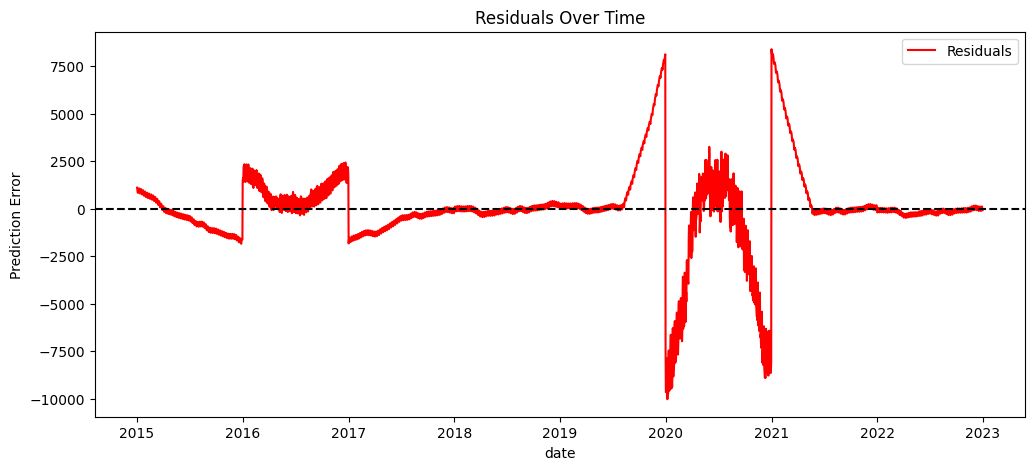

In [208]:
import matplotlib.pyplot as plt

merged_data["Residuals"] = merged_data["loadConsumption"] - merged_data["Final_Prediction"]

plt.figure(figsize=(12, 5))
plt.plot(merged_data["date"], merged_data["Residuals"], label="Residuals", color="red")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("date")
plt.ylabel("Prediction Error")
plt.title("Residuals Over Time")
plt.legend()
plt.show()


In [209]:
prophet = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
prophet.fit(prophet_data)


22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:23 - cmdstanpy - INFO - Chain [1] done processing


In [210]:
# Compute short-term residuals
merged_data["Short_Term_Residual"] = merged_data["loadConsumption"] - merged_data["Long_Term_Trend"]

# Ensure 'date' column is properly formatted
merged_data["date"] = pd.to_datetime(merged_data["date"])

# Prepare data for Prophet
prophet_data = merged_data[["date", "Short_Term_Residual", "DailyMeanTemperature", "DailyMeanWindspeed"]]
prophet_data = prophet_data.rename(columns={"date": "ds", "Short_Term_Residual": "y"})  # Correcting column names

# Initialize Prophet Model
prophet = Prophet()

# Add additional regressors
prophet.add_regressor("DailyMeanTemperature")
prophet.add_regressor("DailyMeanWindspeed")

# Fit Prophet Model
prophet.fit(prophet_data)

# Create future dataframe
future_dates = prophet.make_future_dataframe(periods=180)

# 🔹 **Fix: Extend Last Known Values to Match Future Data Length**
future_dates["DailyMeanTemperature"] = merged_data["DailyMeanTemperature"].iloc[-1]  # Repeat last known value
future_dates["DailyMeanWindspeed"] = merged_data["DailyMeanWindspeed"].iloc[-1]  # Repeat last known value

# Predict short-term variations
short_term_preds = prophet.predict(future_dates)

# Save predictions
merged_data["Final_Prediction"] = merged_data["Long_Term_Trend"] + short_term_preds["yhat"][: len(merged_data)].values

# Save to file
#merged_data.to_csv("/mnt/data/daily_final_predictions_with_regressors.csv", index=False)



22:12:23 - cmdstanpy - INFO - Chain [1] start processing
22:12:24 - cmdstanpy - INFO - Chain [1] done processing


In [211]:
merged_data

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,...,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week,Long_Term_Trend,Short_Term_Residual,Final_Prediction,Residuals
0,2015-01-01,275667.0000,-0.1,-0.1,1,3.0,10,5,4.7,24,...,1,1,2015,1,201501,Thursday,275665.558841,1.441159,273776.939199,1105.300363
1,2015-01-02,319026.0000,4.3,1.7,3,7.3,44,1,10.1,8,...,20,1,2015,1,201501,Friday,319024.332165,1.667835,317180.282275,1032.304570
2,2015-01-03,313131.0000,1.5,0.5,10,3.8,26,17,5.9,1,...,17,1,2015,1,201501,Saturday,313129.362983,1.637017,311415.546032,882.067093
3,2015-01-04,296832.0000,-0.1,-0.1,1,3.9,-3,21,8.0,13,...,1,1,2015,1,201501,Sunday,296830.448193,1.551807,295152.602725,832.526697
4,2015-01-05,350937.0000,0.0,0.0,1,2.4,9,11,3.8,24,...,22,1,2015,2,201502,Monday,350935.165337,1.834663,349067.755401,1009.965222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2022-12-27,291327.2850,1.0,0.5,23,5.7,39,6,7.3,14,...,6,12,2022,52,202252,Tuesday,291513.835143,-186.550143,290533.872793,68.010331
2918,2022-12-28,298608.1775,4.3,0.9,18,9.2,60,1,11.4,24,...,1,12,2022,52,202252,Wednesday,298799.389930,-191.212430,297790.555442,101.703287
2919,2022-12-29,292450.9725,3.5,1.0,2,9.2,65,24,11.7,1,...,24,12,2022,52,202252,Thursday,292638.242191,-187.269691,291609.116786,116.444763
2920,2022-12-30,297210.1750,5.2,2.2,24,8.5,46,7,12.9,22,...,3,12,2022,52,202252,Friday,297400.492225,-190.317225,296415.271066,46.508141


In [212]:
# Ensure we only compare predictions for known dates
actual_values = merged_data["loadConsumption"]
predicted_values = merged_data["Final_Prediction"]

# Compute metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

# Print Metrics
print(f"📊 Model Evaluation Metrics:")
print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
print(f"🔹 Mean Squared Error (MSE): {mse:.2f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"🔹 R² Score: {r2:.4f}")

# Save metrics to a file for reference
metrics_dict = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2_Score": r2
}

import json
with open("prophet_model_metrics.json", "w") as f:
    json.dump(metrics_dict, f)


📊 Model Evaluation Metrics:
🔹 Mean Absolute Error (MAE): 1398.67
🔹 Mean Squared Error (MSE): 5520960.50
🔹 Root Mean Squared Error (RMSE): 2349.67
🔹 R² Score: 0.9949


In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)


,Metric,Value
0,MAE,297.600285
1,MSE,295374.952088
2,RMSE,543.484086
3,R² Score,0.999727
4,MAPE,0.093732


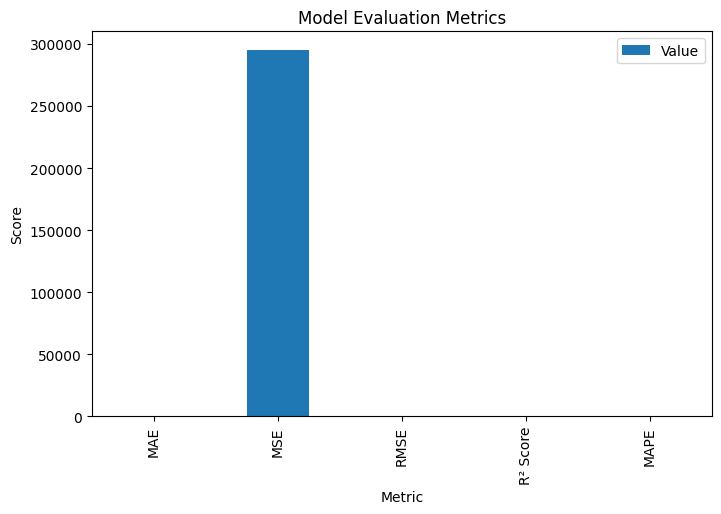

In [98]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R² Score", "MAPE"],
    "Value": [mae, mse, rmse, r2, mape]
})

display(metrics_df)

# Visualization
metrics_df.set_index("Metric").plot(kind="bar", figsize=(8, 5))
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.show()


In [102]:
print(f"Prediction horizon: {len(  y_test_long)} days")


Prediction horizon: 2 days


In [213]:
merged_data

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,...,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week,Long_Term_Trend,Short_Term_Residual,Final_Prediction,Residuals
0,2015-01-01,275667.0000,-0.1,-0.1,1,3.0,10,5,4.7,24,...,1,1,2015,1,201501,Thursday,275665.558841,1.441159,273776.939199,1105.300363
1,2015-01-02,319026.0000,4.3,1.7,3,7.3,44,1,10.1,8,...,20,1,2015,1,201501,Friday,319024.332165,1.667835,317180.282275,1032.304570
2,2015-01-03,313131.0000,1.5,0.5,10,3.8,26,17,5.9,1,...,17,1,2015,1,201501,Saturday,313129.362983,1.637017,311415.546032,882.067093
3,2015-01-04,296832.0000,-0.1,-0.1,1,3.9,-3,21,8.0,13,...,1,1,2015,1,201501,Sunday,296830.448193,1.551807,295152.602725,832.526697
4,2015-01-05,350937.0000,0.0,0.0,1,2.4,9,11,3.8,24,...,22,1,2015,2,201502,Monday,350935.165337,1.834663,349067.755401,1009.965222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2022-12-27,291327.2850,1.0,0.5,23,5.7,39,6,7.3,14,...,6,12,2022,52,202252,Tuesday,291513.835143,-186.550143,290533.872793,68.010331
2918,2022-12-28,298608.1775,4.3,0.9,18,9.2,60,1,11.4,24,...,1,12,2022,52,202252,Wednesday,298799.389930,-191.212430,297790.555442,101.703287
2919,2022-12-29,292450.9725,3.5,1.0,2,9.2,65,24,11.7,1,...,24,12,2022,52,202252,Thursday,292638.242191,-187.269691,291609.116786,116.444763
2920,2022-12-30,297210.1750,5.2,2.2,24,8.5,46,7,12.9,22,...,3,12,2022,52,202252,Friday,297400.492225,-190.317225,296415.271066,46.508141


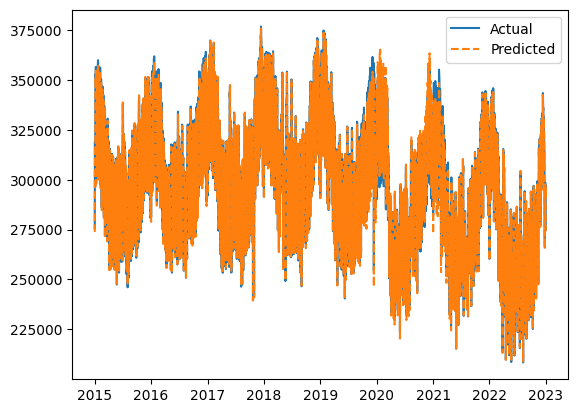

In [214]:
plt.plot(merged_data["date"], merged_data["loadConsumption"], label="Actual")
plt.plot(merged_data["date"], merged_data["Final_Prediction"], label="Predicted", linestyle="--")
plt.legend()
plt.show()
